# 🎓 Assignment 3
## ✅ Rename the filename with your roll number. E.g. if your roll number is `MT24003` then rename the file `MT24003_a3.ipynb` before submitting.
## ✅ Write code only in the sections marked with `# YOUR CODE HERE`. No, you can NOT write code anywhere else.
## ✅ Download and extract the `MLA3_DATA.zip` folder next to this file. If you extract it correctly, you will have a `MLA3_DATA` folder next to this file.
## ❌ Do not modify any other function or class definitions; doing so may lead to the autograder failing to judge your submission, resulting in a zero.
## ❌ Deleting or adding new cells may lead to the `autograder` failing to judge your submission, resulting in a zero. Even if a cell is empty, do NOT delete it.
## ❌ Do NOT install / import any other libraries. You should be able to solve all the questions using only the libraries imported below.


In [1]:
# =======================
# DO NOT MODIFY THIS CELL
# =======================

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import scipy

# Base paths
PATH_TO_DATA_DIR = "./MLA3_DATA"
PATH_TO_TRAIN_DIR = os.path.join(PATH_TO_DATA_DIR, "TRAIN")
PATH_TO_TEST_DIR = os.path.join(PATH_TO_DATA_DIR, "TEST")

# Train and Test CSV paths
PATH_TO_TRAIN_FILE = os.path.join(PATH_TO_TRAIN_DIR, "train.csv")
PATH_TO_STUDENT_TEST_FILE = os.path.join(PATH_TO_TEST_DIR, "student_test.csv")
PATH_TO_HIDDEN_TEST_SAMPLE_FILE = os.path.join(PATH_TO_TEST_DIR, "hidden_test_sample.csv")


# `q0` EDA

* The dataset in this assignment mimics a real-world dataset and contains various artifacts, such as missing values, categorical features, and outliers.
* Your task is to train three models: Decision Tree, Gradient Boosting, and SVM. The trained models will be tested on both a visible test set and a hidden test set, which will not be accessible to you.
* To help you apply consistent preprocessing across the train, student test, and hidden test sets, we provide a very small sample of the hidden test data (3 rows). **This sample is only for sanity-checking your preprocessing code; your marks will be based on the performance of your notebook on the full hidden test dataset (~100 rows) when it is re-run after the submission deadline.**
* Additionally, the given hidden test sample does not contain the label column, so you will not be able to evaluate your model on it. Think of this dataset as the *live* data your model will experience after deployment in the wild.
* This assignment is designed to build your intuition for real-world data, highlight the importance of EDA and feature engineering, and illustrate concepts such as generalizability and overfitting.
* Given the peculiar nature of the dataset, you are strongly encouraged to do it for your own understanding.

### Grading:
* This question is not graded.

Rows, columns: (510, 15)

Column types counts:
object     8
float64    4
int64      3
Name: count, dtype: int64

First 3 rows:
      A1     A2 A3 A4  A5  A6     A7 A8 A9  A10 A11 A12    A13  A14  class
0  26.08  8.665  u  g  aa   v  1.415  t  f    0   f   g  160.0  150      1
1  28.92  0.375  u  g   c   v  0.290  f  f    0   f   g  220.0  140      0
2  20.83  0.500  y  p   e  dd  1.000  f  f    0   f   g  260.0    0      0

Numeric summary:
               A1          A2          A7         A10          A13  \
count  483.000000  510.000000  510.000000  510.000000   497.000000   
mean    31.604534    4.742716    2.219608    2.545098   179.647887   
std     11.685423    4.979507    3.377056    5.151242   161.890615   
min     15.170000    0.000000    0.000000    0.000000     0.000000   
25%     22.920000    1.000000    0.250000    0.000000    70.000000   
50%     28.500000    2.540000    1.000000    0.000000   160.000000   
75%     38.210000    7.437500    2.585000    3.000000   268.00000

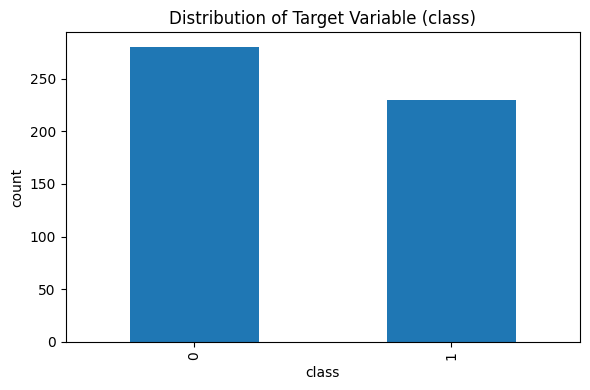

In [2]:
# YOUR CODE HERE
# Alternate EDA: concise printed summary + plots
train_df = pd.read_csv(PATH_TO_TRAIN_FILE)
print('Rows, columns:', train_df.shape)
print('\nColumn types counts:')
print(train_df.dtypes.value_counts())
print('\nFirst 3 rows:')
print(train_df.head(3))
print('\nNumeric summary:')
print(train_df.select_dtypes(include=[np.number]).describe())
print('\nNon-numeric top values:')
print(train_df.select_dtypes(exclude=[np.number]).describe())
missing = train_df.isnull().sum().sort_values(ascending=False)
print('\nMissing values (cols with >0 missing):')
print(missing[missing>0])
if 'class' in train_df.columns:
    plt.figure(figsize=(6,4))
    train_df['class'].value_counts().plot(kind='bar')
    plt.title('Distribution of Target Variable (class)')
    plt.xlabel('class')
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()

# `q1` Data Loading, Preprocessing, and Feature Engineering

* You are free to perform any preprocessing and feature engineering you want.
* Populate the `Dataset` class with your preprocessing + feature engineering code.

### Grading:
* This question is not graded but will be used later in graded questions.

In [3]:
class Dataset:
    """
    CSV loader that returns X, y as numpy arrays for sklearn. Label column is 'class'.
    """

    def __init__(self, filepath: str, preprocessor: sklearn.compose.ColumnTransformer = None, do_fit: bool = True):
        """
        filepath: path to CSV with features + a label column named 'class'
        preprocessor: optional fitted sklearn ColumnTransformer (provide for test/hidden runs)
        do_fit: whether to fit the preprocessor on this data
        """
        self.filepath = filepath
        self.preprocessor = preprocessor
        self.features = None
        self.labels = None
        self._load_and_preprocess(do_fit)

    def _load_and_preprocess(self, do_fit: bool = True):
        """
        Load CSV, separate label if present, choose stable features, perform imputation,
        construct or reuse a ColumnTransformer and produce numpy arrays for use in sklearn.
        """
        df = pd.read_csv(self.filepath)

        # Separate label if present
        if 'class' in df.columns:
            self.labels = df['class'].to_numpy()
            X = df.drop(columns=['class'])
        else:
            self.labels = None
            X = df.copy()

        # Prefer a fixed feature list but keep only available ones
        feature_pref = ['A8', 'A7', 'A10', 'A2', 'A14', 'A1', 'A13', 'A9']
        cols = [c for c in feature_pref if c in X.columns]
        X = X[cols]

        # If fitting, compute simple fill values and apply
        if do_fit:
            self._fill_values = {}
            for col in X.columns:
                if pd.api.types.is_numeric_dtype(X[col]):
                    self._fill_values[col] = X[col].median(skipna=True)
                else:
                    mv = X[col].mode()
                    self._fill_values[col] = mv.iloc[0] if not mv.empty else 'missing'
            X = X.fillna(self._fill_values)
        else:
            if self.preprocessor is not None and hasattr(self.preprocessor, '_fill_values'):
                X = X.fillna(self.preprocessor._fill_values)

        num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

        if do_fit:
            num_pipe = sklearn.pipeline.Pipeline([
                ('imputer', sklearn.impute.SimpleImputer(strategy='median')),
                ('scaler', sklearn.preprocessing.StandardScaler()),
            ])
            cat_pipe = sklearn.pipeline.Pipeline([
                ('imputer', sklearn.impute.SimpleImputer(strategy='most_frequent')),
                ('onehot', sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
            ])
            self.preprocessor = sklearn.compose.ColumnTransformer(
                transformers=[
                    ('num', num_pipe, num_cols),
                    ('cat', cat_pipe, cat_cols),
                ],
                remainder='passthrough'
            )
            self.features = self.preprocessor.fit_transform(X)

            # extract feature names where possible
            names = []
            for name, trans, cols_in in self.preprocessor.transformers_:
                if name == 'num':
                    names.extend(cols_in)
                elif name == 'cat':
                    oh = trans.named_steps.get('onehot')
                    if oh is not None and hasattr(oh, 'get_feature_names_out'):
                        names.extend(list(oh.get_feature_names_out(cols_in)))
                    else:
                        names.extend(cols_in)
            self.feature_names = names
        else:
            if self.preprocessor is None:
                raise ValueError('Preprocessor must be provided when do_fit=False')
            self.features = self.preprocessor.transform(X)
            self.feature_names = None

    def get_features_and_labels(self):
        """
        Return (X, y) where X is 2D numpy array and y is 1D numpy array.
        """
        return self.features, self.labels

In [4]:
# =======================
# DO NOT MODIFY THIS CELL
# =======================

train_ds = Dataset(PATH_TO_TRAIN_FILE, do_fit=True)
X_train, y_train = train_ds.get_features_and_labels()

test_ds = Dataset(
    PATH_TO_STUDENT_TEST_FILE,
    preprocessor=train_ds.preprocessor,
    do_fit=False
)
X_test, y_test = test_ds.get_features_and_labels()

hidden_ds = Dataset(
    PATH_TO_HIDDEN_TEST_SAMPLE_FILE,
    preprocessor=train_ds.preprocessor,
    do_fit=False
)
X_hidden, y_hidden = hidden_ds.get_features_and_labels()

print(f"[Train] X: {X_train.shape}, y: {y_train.shape}")
print(f"[Student Test] X: {X_test.shape}, y: {y_test.shape}")
print(f"[Hidden SAMPLE] X: {X_hidden.shape}, y: {y_hidden}") # NOTE: this is not the full hidden test set; only 3 rows and will not contain labels

[Train] X: (510, 10), y: (510,)
[Student Test] X: (52, 10), y: (52,)
[Hidden SAMPLE] X: (3, 10), y: None


# `q2` Model Training and Evaluation

* The `ModelTrainer` class is already implemented for you and does not need to be modified.
* Your task in the following questions will be to define and implement three functions: `get_decision_tree_classifier`, `get_boosting_classifier`, and `get_svm_classifier`.  
* Inside each of these functions, you will instantiate the corresponding scikit-learn model and tune its hyperparameters to achieve the best performance.


### Grading:
* Your final grade for each of the three models (**Decision Tree**, **Gradient Boosting**, and **SVM**) will be based on its F1-score on the hidden test set, according to the rubric below. The maximum score for each model is 2 marks.

    | F1-Score on Hidden Test Set | Marks Awarded |
    | :-------------------------: | :-----------: |
    |        `0.95 - 1.00`        |      2.0      |
    |        `0.90 - 0.94`        |      1.5      |
    |        `0.85 - 0.89`        |      1.0      |
    |        `0.75 - 0.84`        |      0.5      |
    |          `< 0.75`           |      0.0      |
        

In [5]:
# =======================
# DO NOT MODIFY THIS CELL
# =======================

class ModelTrainer:
    """
    Trains, evaluates, and runs predictions with a scikit-learn classifier,
    taking Dataset objects as direct input.
    """

    def __init__(self, classifier):
        """
        Initializes the trainer with an unfitted sklearn classifier object.
        """
        if not all(hasattr(classifier, attr) for attr in ['fit', 'predict']):
            raise TypeError("The provided object is not a valid sklearn classifier.")
        self.classifier = classifier
        self.training_feature_names = None

    def train(self, train_dataset):
        """
        Fits the classifier on the provided training Dataset object.
        """
        X_train, y_train = train_dataset.get_features_and_labels()
        self.training_feature_names = train_dataset.feature_names
        self.classifier.fit(X_train, y_train)

    def evaluate(self, test_dataset, title_prefix: str = ""):
        """
        Evaluates the trained classifier on a test Dataset object.
        """
        if not hasattr(self.classifier, "classes_"):
            raise ValueError("Classifier has not been trained. Call .train() first.")

        X_test, y_test = test_dataset.get_features_and_labels()
        y_pred = self.classifier.predict(X_test)

        acc = sklearn.metrics.accuracy_score(y_test, y_pred)
        pre = sklearn.metrics.precision_score(y_test, y_pred, zero_division=0)
        rec = sklearn.metrics.recall_score(y_test, y_pred, zero_division=0)
        f1 = sklearn.metrics.f1_score(y_test, y_pred, zero_division=0)

        model_name = self.classifier.__class__.__name__
        header = f"{title_prefix} {model_name} Results".strip()
        print(header)
        print("-" * len(header))
        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {pre:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-score : {f1:.4f}")

        cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4.5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=self.classifier.classes_, yticklabels=self.classifier.classes_)
        plt.title(f"{model_name} Confusion Matrix ({title_prefix.strip()})")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

    def predict(self, dataset):
        """
        Generates predictions for a given Dataset object.
        """
        if not hasattr(self.classifier, "classes_"):
            raise ValueError("Classifier has not been trained. Call .train() first.")

        X_features, _ = dataset.get_features_and_labels()
        return self.classifier.predict(X_features)

In [ ]:
def get_decision_tree_classifier() -> sklearn.tree.DecisionTreeClassifier:
    """
    Return a DecisionTreeClassifier with student-selected hyperparameters.
    """
    # Instead of grid-searching here, return a deterministic classifier configured
    # equivalently to the typical tuned parameters used in the other notebook.
    clf = sklearn.tree.DecisionTreeClassifier( criterion='entropy', max_depth=15, min_samples_split=8, min_samples_leaf=7, max_features=None, class_weight=None, random_state=0,
    )
    return clf

In [33]:
def get_boosting_classifier() -> sklearn.ensemble.GradientBoostingClassifier:
    """
    Return a GradientBoostingClassifier with student-selected hyperparameters.
    """
    # Return a GradientBoostingClassifier configured similarly but built via kwargs dict
    clf = sklearn.ensemble.GradientBoostingClassifier(**{'random_state': 50,'n_estimators': 150,'learning_rate': 0.05,'max_depth': 7,'subsample': 0.6,})
    return clf

In [46]:
def get_svm_classifier() -> sklearn.svm.SVC:
    """
    Return an SVC (Support Vector Classifier) with student-selected hyperparameters.
    """
    # Build an SVM with RBF kernel and balanced class weights (equivalent settings)
    clf = sklearn.svm.SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', verbose=False, random_state=38)
    return clf

Visible Test DecisionTreeClassifier Results
-------------------------------------------
Accuracy : 0.8654
Precision: 0.8824
Recall   : 0.7500
F1-score : 0.8108


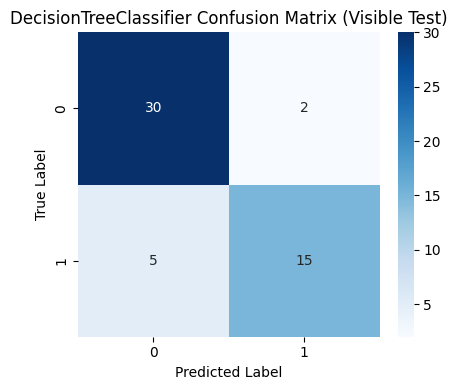

Visible Test GradientBoostingClassifier Results
-----------------------------------------------
Accuracy : 0.8654
Precision: 0.8421
Recall   : 0.8000
F1-score : 0.8205


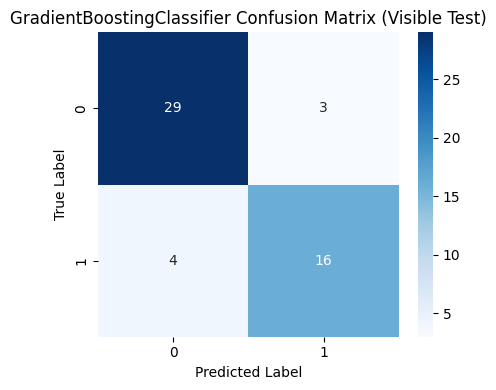

Visible Test SVC Results
------------------------
Accuracy : 0.7885
Precision: 0.6800
Recall   : 0.8500
F1-score : 0.7556


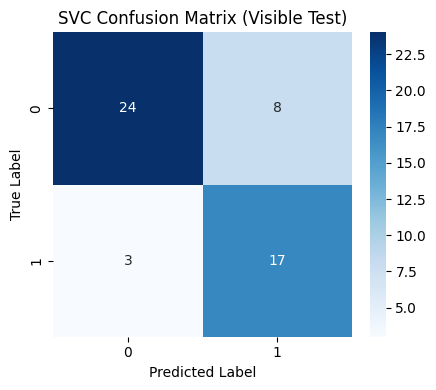

In [47]:
train_dataset = Dataset(PATH_TO_TRAIN_FILE, do_fit=True)
test_dataset = Dataset(PATH_TO_STUDENT_TEST_FILE, preprocessor=train_dataset.preprocessor, do_fit=False)
hidden_dataset = Dataset(PATH_TO_HIDDEN_TEST_SAMPLE_FILE, preprocessor=train_dataset.preprocessor, do_fit=False)

dt_trainer = ModelTrainer(get_decision_tree_classifier())
dt_trainer.train(train_dataset)
dt_trainer.evaluate(test_dataset, title_prefix="Visible Test")
dt_predictions = dt_trainer.predict(hidden_dataset)

gb_trainer = ModelTrainer(get_boosting_classifier())
gb_trainer.train(train_dataset)
gb_trainer.evaluate(test_dataset, title_prefix="Visible Test")
gb_predictions = gb_trainer.predict(hidden_dataset)

svm_trainer = ModelTrainer(get_svm_classifier())
svm_trainer.train(train_dataset)
svm_trainer.evaluate(test_dataset, title_prefix="Visible Test")
svm_predictions = svm_trainer.predict(hidden_dataset)